## Dynamic Programming

### Steps
**1) Subproblems:**

Let the shortest path between two nodes x and y be c(x,y).

**2) Problem:**

Given i,j for all x,y the answer to our problem is c(i,j).

**3) Base Cases:**
* c(i,j) = null for all i,j
* c(k,k) = 0 for all vertices k in a graph G
* c(i,j) = 1 for all edges i,j in a graph G

**4) Solution:**

For each vertex k in a graph G, we need to iterate through each edge (i,j) in G and determine if there is a possible path from k to j.

If c(k,j) is null and c(k,i) is not null, then c(k,j) = c(k,i) + w(i,j) where w(i,j) is the weight of the edge (i,j). Repeat this process for each node until no further changes can be made.

**Pseudocode:**

```
set A to [][]
set A[k][k] to 0 for each node k in G
set A[i][j] to 1 for each edge i->j in G
for each node k in G:
    set changed to True
    while changed is True:
        set changed to False
        for each edge i->j in G:
            if A[k][j] is null:
                if A[k][i] is not null:
                    set A[k][j] to A[k][i] + weight(i->j)
                    set changed to True

return A[start][target]        
```

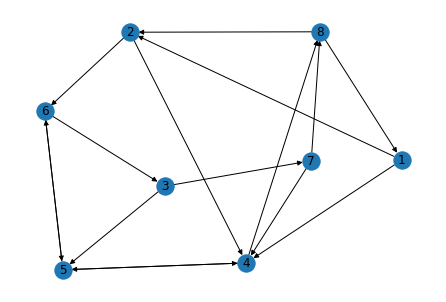

In [1]:
### Create random graph
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from([1,2,3,4,5,6,7,8])

# Edges with weights
edges = [
    (1,2,1),(1,4,2),
    (2,4,1),(2,6,2),
    (3,5,6),(3,7,3),
    (4,8,1),(4,5,2),
    (5,4,2),(5,6,1),
    (6,3,2),(6,5,2),
    (7,8,3),(7,4,5),
    (8,1,4),(8,2,4)
]

G.add_weighted_edges_from(edges)

pos = nx.spring_layout(G, seed=47906)
nx.draw(G,pos=pos,with_labels=True)

In [2]:
# Find shortest path in a graph using dynamic programming
def shortest_path_dynamic(G,s,t,flight_time=False):
    nodes = list(G.nodes)
    edges = list(G.edges.data())
    
    # Create empty matrix
    A = [[None for _ in range(len(nodes)+1)] for _ in range(len(nodes)+1)]

    # Base cases
    for k in nodes:
        A[k][k] = 0
    for i,j,w in edges:
        # If flight_time is true, then the weight becomes the average flight
        # time between the two airports
        # Otherwise, the weight is 1
        if flight_time:
            A[i][j] = w['weight']
        else:
            A[i][j] = 1
        
    # Loop through nodes
    for k in nodes:
        changed = True
        while changed:
            changed = False
            # Loop through edges
            for i,j,w in edges:
                if A[k][j] == None:
                    if A[k][i] != None:
                        # If flight_time is true, add the average flight time between
                        # the two airports. Otherwise, add 1
                        if flight_time:
                            A[k][j] = A[k][i] + w['weight']
                        else:
                            A[k][j] = A[k][i] + 1
                        changed = True
                else:
                    if flight_time:
                        if A[k][i] != None:
                            if A[k][i] + w['weight'] < A[k][j]:
                                A[k][j] = A[k][i] + w['weight']
                                changed=True

    return A[s][t]

    
# Test function
shortest_path_dynamic(G,1,7)

4

We can see that in the sample graph that we created above, we can traverse from node **1** to node **7** in *4* moves.

**1 --> 2 --> 6 --> 3 --> 7**

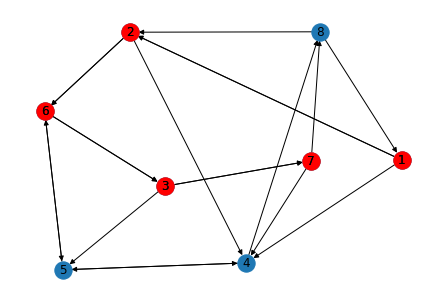

In [3]:
nx.draw(G,pos=pos,with_labels=True)
nx.draw(G.subgraph([1,2,3,6,7]),pos=pos,node_color='red',with_labels=True)

### Apply Algorithm to Flights

In [4]:
import pandas as pd
import csv
import numpy as np

In [5]:
# Load in airport data
data = pd.read_csv("../data/airport.csv")
data.head()

,Unnamed: 0,ORIGIN,DEST,MEAN_ELAPSED_TIME,NUM_TRAVEL
0,0,ABE,ATL,125.76,89
1,1,ABE,CLT,127.39,89
2,2,ABE,DTW,106.86,85
3,3,ABE,FLL,166.00,4
4,4,ABE,MYR,93.18,22


In [6]:
# Get all airports listed in the data
departure = data.ORIGIN.unique()
destination = data.DEST.unique()

In [7]:
# Dictionary of ids
# key=airport id, value=counter
ids={}
count = 0
for node in set(list(departure)+list(destination)):
    ids[node] = count
    count += 1
    
# Inverse of ids
ids_inv = {v:k for k,v in ids.items()}

# Create graph from data
G = nx.DiGraph()
G.add_nodes_from(ids.values())

# Add weighted edges between each pair of airports
all_trips = []
for idx, row in data.iterrows():
    all_trips.append((ids[row.ORIGIN], ids[row.DEST], row.MEAN_ELAPSED_TIME))

G.add_weighted_edges_from(all_trips)

### Let's go on a trip

We want to go on a trip to Hawaii, but we don't know how long it would take to get there. If there are two or more layovers, then we will likely need to find a different destination.

In [8]:
shortest_path_dynamic(G, ids['IND'],ids['HNL'])

2

Lucky for us! It appears that there will only be one layover if we fly from Indianapolis to Honolulu. Let's check and see how long we will be on the plane.

In [9]:
shortest_path_dynamic(G, ids['IND'], ids['HNL'], flight_time=True)

594.92

594 minutes is nearly 10 hours! That's a long time to be on an airplane, not counting the actual layover time. Is it worth it?